# Random Forest multietiqueta con búsqueda Repeated K‑Fold
Implementamos un **Random Forest** para clasificación multietiqueta de eventos sísmicos, con optimización de hiperparámetros mediante **Repeated K‑Fold CV** (5×3). Se muestran:
1. Gráfica de optimización de λ (λ ≡ `ccp_alpha` del árbol).
2. Curva de aprendizaje (tamaño de entrenamiento vs F1‑micro).
> Nota: `ccp_alpha` actúa como parámetro de regularización en cada árbol; mayor λ ⇒ mayor poda ⇒ modelo más simple.

## Bloque 1 – Importaciones
Incluimos `RepeatedKFold`, `MultiOutputClassifier` y métricas.

In [1]:
# ----- Bloque 1 -----
import os, joblib, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, hamming_loss, make_scorer


## Bloque 2 – Ruta


In [2]:
# ----- Bloque 2 -----
if os.path.basename(os.getcwd()) != 'Seismic-Multilabel-Event-Classifier':
    os.chdir('..')
    print('CWD cambiado ->', os.getcwd())

CWD cambiado -> /Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier


## Bloque 3 – Carga de datos


In [3]:
# ----- Bloque 3 -----
df = pd.read_json('data/processed/dataset_final.json')
print('Shape:', df.shape)
df.head()

Shape: (1674, 92)


,max_V,rms_V,max_H1,rms_H1,max_H2,rms_H2,duration,zcr_V,dom_freq_V,centroid_V,...,1 Stiker Slip (SS),2 Normal-Oblique (SO),3 Reverse-Oblique (RO),4-6,6-8,0-200,200-400,400-600,600-,label
0,0.000342,0.000052,0.000587,0.000111,0.000617,0.000107,321.68,2.014362,0.000000,5.447156,...,True,False,False,True,False,False,False,False,True,1 Stiker Slip (SS) | 4-6 | 600-
1,0.003967,0.000347,0.006399,0.000501,0.004988,0.000475,200.00,9.034548,0.781250,17.551070,...,True,False,False,True,False,False,False,False,True,1 Stiker Slip (SS) | 4-6 | 600-
2,0.000135,0.000023,0.000204,0.000028,0.000157,0.000026,323.79,1.429895,0.195312,2.573894,...,True,False,False,True,False,False,False,False,True,1 Stiker Slip (SS) | 4-6 | 600-
3,0.003166,0.000453,0.005030,0.000657,0.004669,0.000725,41.00,21.189954,14.062500,14.019404,...,True,False,False,True,False,False,False,False,True,1 Stiker Slip (SS) | 4-6 | 600-
4,0.000011,0.000002,0.000021,0.000003,0.000018,0.000003,180.80,3.943366,0.195312,10.936094,...,True,False,False,True,False,False,False,False,True,1 Stiker Slip (SS) | 4-6 | 600-


## Bloque 4 – Separación X / y


In [4]:
# ----- Bloque 4 -----
label_cols = ['1 Stiker Slip (SS)','2 Normal-Oblique (SO)','3 Reverse-Oblique (RO)',
              '4-6','6-8','0-200','200-400','400-600','600-']
drop_cols = ['Archivo','Falla_lbl','Mag_lbl','Vs_lbl','Combo'] + label_cols
feature_cols = [c for c in df.columns if c not in drop_cols]

X = df[feature_cols].values
y = df[label_cols].values

print('X:', X.shape, 'y:', y.shape)

X: (1674, 83) y: (1674, 9)


## Bloque 5 – Hold‑out Test (20 %)


In [5]:
# ----- Bloque 5 -----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
print('Train:', X_train.shape, ' Test:', X_test.shape)

Train: (1339, 83)  Test: (335, 83)


## Bloque 6 – Pipeline base


In [6]:
# ----- Bloque 6 -----
base_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', MultiOutputClassifier(RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )))
])

## Bloque 7 – Grid y Repeated K‑Fold


In [7]:
# ----- Bloque 7 -----
# Definimos λ = ccp_alpha
lambda_vals = np.concatenate(([0.0], np.logspace(-4, -1, 4)))  # 0, 1e‑4,1e‑3,1e‑2,1e‑1
param_grid = {'clf__estimator__ccp_alpha': lambda_vals}

rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
scorer = make_scorer(f1_score, average='micro')

grid = GridSearchCV(
    base_pipe,
    param_grid=param_grid,
    scoring=scorer,
    cv=rkf,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)
print('Mejor λ (ccp_alpha):', grid.best_params_['clf__estimator__ccp_alpha'])
print('Mejor F1‑micro CV:', grid.best_score_)

Fitting 50 folds for each of 5 candidates, totalling 250 fits
[CV] END ......................clf__estimator__ccp_alpha=0.0; total time=   0.0s
[CV] END ......................clf__estimator__ccp_alpha=0.0; total time=   0.0s
[CV] END ......................clf__estimator__ccp_alpha=0.0; total time=   0.0s
[CV] END ......................clf__estimator__ccp_alpha=0.0; total time=   0.0s
[CV] END ......................clf__estimator__ccp_alpha=0.0; total time=   0.0s
[CV] END ......................clf__estimator__ccp_alpha=0.0; total time=   0.0s
[CV] END ......................clf__estimator__ccp_alpha=0.0; total time=   0.0s
[CV] END ......................clf__estimator__ccp_alpha=0.0; total time=   0.0s
[CV] END ......................clf__estimator__ccp_alpha=0.0; total time=   0.0s
[CV] END ......................clf__estimator__ccp_alpha=0.0; total time=   0.0s
[CV] END ......................clf__estimator__ccp_alpha=0.0; total time=   0.0s
[CV] END ......................clf__estimator__

ValueError: 
All the 250 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/pipeline.py", line 654, in fit
    Xt = self._fit(X, y, routed_params, raw_params=params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/pipeline.py", line 588, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/pipeline.py", line 1551, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/base.py", line 921, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/preprocessing/_data.py", line 894, in fit
    return self.partial_fit(X, y, sample_weight)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/preprocessing/_data.py", line 930, in partial_fit
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/utils/validation.py", line 2944, in validate_data
    out = check_array(X, input_name="X", **check_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1055, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/utils/_array_api.py", line 839, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: '2 Normal-Oblique (SO) | 6-8 | 400-600'

--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/pipeline.py", line 654, in fit
    Xt = self._fit(X, y, routed_params, raw_params=params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/pipeline.py", line 588, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/pipeline.py", line 1551, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/base.py", line 921, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/preprocessing/_data.py", line 894, in fit
    return self.partial_fit(X, y, sample_weight)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/preprocessing/_data.py", line 930, in partial_fit
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/utils/validation.py", line 2944, in validate_data
    out = check_array(X, input_name="X", **check_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1055, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/utils/_array_api.py", line 839, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: '1 Stiker Slip (SS) | 4-6 | 400-600'

--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/pipeline.py", line 654, in fit
    Xt = self._fit(X, y, routed_params, raw_params=params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/pipeline.py", line 588, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/pipeline.py", line 1551, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/base.py", line 921, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/preprocessing/_data.py", line 894, in fit
    return self.partial_fit(X, y, sample_weight)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/preprocessing/_data.py", line 930, in partial_fit
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/utils/validation.py", line 2944, in validate_data
    out = check_array(X, input_name="X", **check_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1055, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/sklearn/utils/_array_api.py", line 839, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: '3 Reverse-Oblique (RO) | 6-8 | 600-'


## Bloque 8 – Optimización de λ


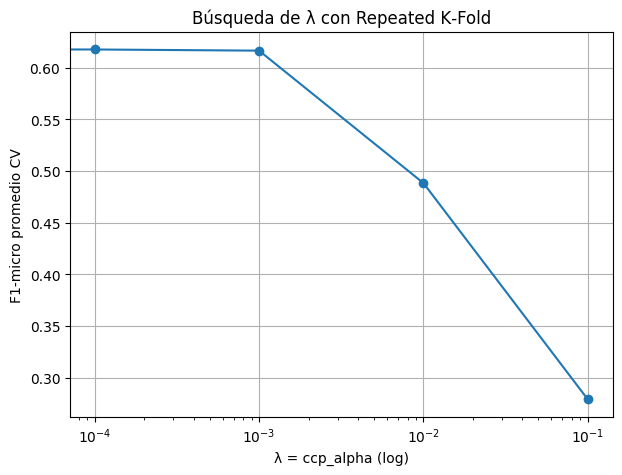

In [ ]:
# ----- Bloque 8 -----
results = pd.DataFrame(grid.cv_results_)
results['lambda'] = results['param_clf__estimator__ccp_alpha'].astype(float)
means = results.sort_values('lambda').groupby('lambda')['mean_test_score'].mean()

plt.figure(figsize=(7,5))
plt.plot(means.index, means.values, marker='o')
plt.xscale('log')
plt.xlabel('λ = ccp_alpha (log)')
plt.ylabel('F1‑micro promedio CV')
plt.title('Búsqueda de λ con Repeated K‑Fold')
plt.grid(True)
plt.show()

## Bloque 9 – Curva de aprendizaje


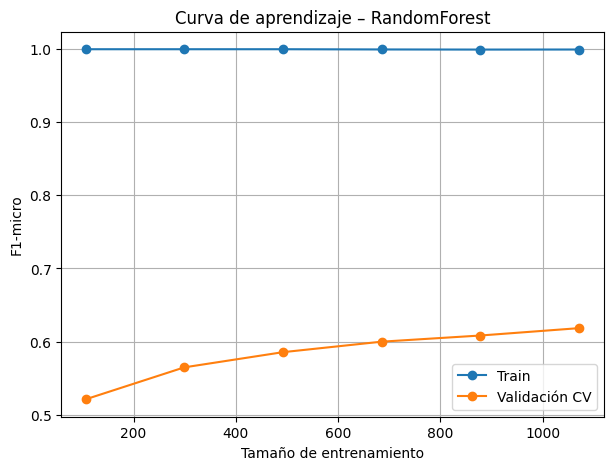

In [ ]:
# ----- Bloque 9 -----
best_lambda = grid.best_params_['clf__estimator__ccp_alpha']
best_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', MultiOutputClassifier(RandomForestClassifier(
        n_estimators=200,
        ccp_alpha=best_lambda,
        random_state=42,
        n_jobs=-1
    )))
])

train_sizes, tr_scores, val_scores = learning_curve(
    best_pipe, X_train, y_train,
    cv=rkf, scoring=scorer,
    train_sizes=np.linspace(0.1, 1.0, 6),
    n_jobs=-1
)

plt.figure(figsize=(7,5))
plt.plot(train_sizes, tr_scores.mean(axis=1), marker='o', label='Train')
plt.plot(train_sizes, val_scores.mean(axis=1), marker='o', label='Validación CV')
plt.xlabel('Tamaño de entrenamiento')
plt.ylabel('F1‑micro')
plt.title('Curva de aprendizaje – RandomForest')
plt.legend()
plt.grid(True)
plt.show()

## Bloque 10 – Evaluación en Test


In [ ]:
# ----- Bloque 10 -----
best_pipe.fit(X_train, y_train)
y_pred = best_pipe.predict(X_test)

f1 = f1_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')
hl = hamming_loss(y_test, y_pred)

print(f'Test F1‑micro: {f1:.4f}')
print(f'Test F1‑macro: {f1_macro:.4f}')
print(f'Test Hamming loss: {hl:.4f}')

Test F1‑micro: 0.6391
Test F1‑macro: 0.5505
Test Hamming loss: 0.2027


## Bloque 11 – Guardar modelo


In [ ]:
# ----- Bloque 11 -----
os.makedirs('models', exist_ok=True)
joblib.dump(best_pipe, 'models/rf_repkfold.pkl')
print('Modelo guardado en models/rf_repkfold.pkl')

Modelo guardado en models/rf_repkfold.pkl
